In [2]:
import augur
from augur.githubapi import GitHubAPI
from augur.ghtorrent import GHTorrent

# import everything from githubapi.py and ghtorrent.py so we can
# just copy and paste our function later
import json
import re
from dateutil.parser import parse
import pandas as pd
import github
import numpy as np
import sqlalchemy as s
import datetime
import requests
import time

%matplotlib inline
# create an Augur application so we can test our function
augurApp = augur.Application('../augur.config.json')
github = augurApp.githubapi()
ghtorrent = augurApp.ghtorrent()


## GitHub API Example Function

In [5]:
# We are writing this function to be run as part of the GitHub class, so 
# the "self" in this function will be an instance of an augur.GitHubAPI
def lines_deleted(self, owner, repo=None): 
    """
    Additions and deletions each week

    :param owner: The name of the project owner
    :param repo: The name of the repo
    :return: DataFrame with each row being am issue
    """
    # get the data we need from the GitHub API
    # see <project_root>/augur/githubapi.py for examples using the GraphQL API
    url = "https://api.github.com/repos/{}/{}/stats/code_frequency".format(owner, repo)
    json = requests.get(url, auth=('user', self.GITHUB_API_KEY)).json()
    # get our data into a dataframe
    df = pd.DataFrame(json, columns=['date', 'additions', 'deletions'])
    # all timeseries metrics need a 'date' column
    df['date'] = pd.to_datetime(df['date'], unit='s', infer_datetime_format=True)
    # normalize our data and create useful aggregates
    df['deletions'] = df['deletions'] * -1
    df.drop(columns=['additions'])
    # return the dataframe
    return df

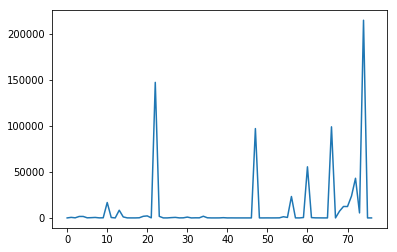

In [6]:
# add our new function to the class
GitHubAPI.lines_deleted = lines_deleted

# test our function on the initialized instance
ld = github.lines_deleted('osshealth', 'augur')
ld['deletions'].plot()


## GHTorrent Example Function

In [6]:
# all Augur functions that provide data should accept at least these arguments
#
# we are writing this function to be run as part of the GHTorrent class, so 
# the "self" in this function will be an instance of an augur.GHTorrent
def issues_closed_by_month(self, owner, repo=None):
        # get the repoid we will need in our query
        repoid = self.repoid(owner, repo)
        # write our query
        sql = s.sql.text("""
        SELECT DATE_FORMAT(issue_events.created_at, '%Y-%m') as "date", COUNT(*) as issues_closed
            FROM issue_events, issues
            WHERE issue_events.issue_id = issues.id
            AND issue_events.action = "closed"
            AND issues.repo_id = :repoid
            GROUP BY YEAR(issue_events.created_at), MONTH(issue_events.created_at)
        """)
        # return a dataframe of the results of the query
        return pd.read_sql(sql, self.db, params={"repoid": str(repoid)})


# add our new function to the class
GHTorrent.issues_closed_by_month = issues_closed_by_month

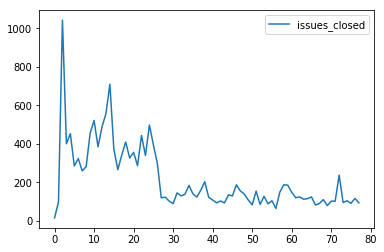

In [7]:
# test our function on the initialized instance
rails_closed_per_month = ghtorrent.issues_closed_by_month('rails', 'rails')
rails_closed_per_month.plot()